In [1]:
import numpy as np
from qiskit import QuantumCircuit
from scipy.optimize import minimize
from qiskit.quantum_info import Statevector

def build_A(N, nu, dt, h):
    alpha = nu * dt / (h**2)
    diag = np.ones(N) * (1 + 2*alpha)
    off = np.ones(N-1) * (-alpha)
    A = np.diag(diag) + np.diag(off, 1) + np.diag(off, -1)
    return A

def advect_upwind(u, dt, h):
    N = len(u)
    ustar = u.copy()
    for i in range(1, N-1):
        dudx = (u[i] - u[i-1]) / h
        ustar[i] = u[i] - dt * u[i] * dudx
    ustar[0] = 0.0
    ustar[-1] = 0.0
    return ustar

def ansatz_circuit(n_qubits, params, reps=3):
    qc = QuantumCircuit(n_qubits)
    idx = 0
    for r in range(reps):
        for q in range(n_qubits):
            qc.ry(params[idx], q)
            idx += 1
        for q in range(n_qubits - 1):
            qc.cx(q, q+1)
    return qc

def get_statevector_from_circuit(qc):
    sv = Statevector.from_instruction(qc)
    return np.array(sv.data, dtype=complex)

def pad_to_power_of_two(vec):
    N = len(vec)
    target = 1
    while target < N:
        target *= 2
    if target == N:
        return vec
    padded = np.zeros(target, dtype=complex)
    padded[:N] = vec
    return padded

def amplitude_state_prep_circuit(vec):
    vec = np.array(vec, dtype=complex)
    n = int(np.log2(len(vec)))
    qc = QuantumCircuit(n)
    qc.initialize(vec.tolist(), list(range(n)))
    return qc

class VQLS_Prototype:
    def __init__(self, A, b_vec, n_qubits, reps=3):
        self.A = np.array(A, dtype=float)
        self.N = A.shape[0]
        self.n_qubits = n_qubits
        self.reps = reps
        b_norm = np.linalg.norm(b_vec)
        if b_norm == 0:
            raise ValueError("b is zero vector")
        self.b = np.array(b_vec, dtype=float)
        self.b_sv = self.b / b_norm
        self.b_sv_padded = pad_to_power_of_two(self.b_sv)
        self.b_prep_circ = amplitude_state_prep_circuit(self.b_sv_padded)
        self.b_norm = b_norm

    def cost(self, params):
        qc = ansatz_circuit(self.n_qubits, params, reps=self.reps)
        sv = get_statevector_from_circuit(qc)
        x_sv = sv[:self.N]
        Ax = self.A.dot(x_sv)
        diff = Ax - self.b_sv
        val = np.vdot(diff, diff).real
        return float(val)

    def reconstruct_solution(self, params):
        u_classical = np.linalg.solve(self.A, self.b)
        norm_u = np.linalg.norm(u_classical)
        qc = ansatz_circuit(self.n_qubits, params, reps=self.reps)
        sv = get_statevector_from_circuit(qc)
        x_sv = sv[:self.N]
        u_rec = x_sv * norm_u
        return u_rec.real, u_classical

# ------------------- Classical solver -------------------
def run_classical_solver(max_steps=500, tolerance=1e-3):
    N = 8
    nu = 0.01
    h = 1.0 / (N + 1)
    dt = 1e-3
    A = build_A(N, nu, dt, h)
    x_grid = np.linspace(1, N, N) * h
    u_n = np.sin(np.pi * x_grid)
    print("Classical solver: Initial u:", np.round(u_n, 5))

    for step in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_new = np.linalg.solve(A, u_star)
        residual = np.linalg.norm(u_new - u_n)
        print(f"[Classical] Step {step+1}: Residual = {residual:.5e}")
        if residual < tolerance:
            print(f"[Classical] Converged at step {step+1}, residual={residual:.5e}")
            break
        u_n = u_new

    print("Classical Final solution:", np.round(u_n, 5))
    return u_n

# ------------------- VQLS solver -------------------
def run_vqls_solver(max_steps=500, tolerance=1e-3):
    N = 8
    n_qubits = int(np.log2(N)) 
    nu = 0.01
    h = 1.0 / (N + 1)
    dt = 1e-3
    A = build_A(N, nu, dt, h)
    x_grid = np.linspace(1, N, N) * h
    u_n = np.sin(np.pi * x_grid)
    print("VQLS solver: Initial u:", np.round(u_n, 5))

    n_params = 10 * n_qubits
    last_params = 0.1 * np.random.randn(n_params) 

    for step in range(max_steps):
        print(f"\n--- VQLS Step {step+1} ---")
        u_star = advect_upwind(u_n.copy(), dt, h)
        vqls = VQLS_Prototype(A=A, b_vec=u_star, n_qubits=n_qubits, reps=10)
        
        res = minimize(vqls.cost, 
                       last_params,
                       method='COBYLA', 
                       options={'maxiter': 2000})

        last_params = res.x

        print(f"Optimizer result: cost = {res.fun:.5e}, nfev = {res.nfev}")

        u_rec, u_classical = vqls.reconstruct_solution(res.x)
        residual = np.linalg.norm(u_rec - u_n)
        print(f"[VQLS] Step {step+1}: Residual = {residual:.5e}")

        if residual < tolerance:
            print(f"[VQLS] Converged at step {step+1}, residual={residual:.5e}")
            break

        u_n = u_rec

    print("\nVQLS Final solution:", np.round(u_n, 5))
    return u_n

In [35]:
run_vqls_solver()

VQLS solver: Initial u: [0.34202 0.64279 0.86603 0.98481 0.98481 0.86603 0.64279 0.34202]

--- VQLS Step 1 ---
Optimizer result: cost = 3.36284e-08, nfev = 365
[VQLS] Step 1: Residual = 4.82958e-01

--- VQLS Step 2 ---
Optimizer result: cost = 3.39389e-08, nfev = 233
[VQLS] Step 2: Residual = 4.75082e-03

--- VQLS Step 3 ---
Optimizer result: cost = 3.36315e-08, nfev = 218
[VQLS] Step 3: Residual = 4.72021e-03

--- VQLS Step 4 ---
Optimizer result: cost = 3.30213e-08, nfev = 202
[VQLS] Step 4: Residual = 4.64922e-03

--- VQLS Step 5 ---
Optimizer result: cost = 3.30602e-08, nfev = 231
[VQLS] Step 5: Residual = 4.60466e-03

--- VQLS Step 6 ---
Optimizer result: cost = 3.32968e-08, nfev = 235
[VQLS] Step 6: Residual = 4.58851e-03

--- VQLS Step 7 ---
Optimizer result: cost = 3.30065e-08, nfev = 216
[VQLS] Step 7: Residual = 4.56868e-03

--- VQLS Step 8 ---
Optimizer result: cost = 3.31615e-08, nfev = 225
[VQLS] Step 8: Residual = 4.54965e-03

--- VQLS Step 9 ---
Optimizer result: cost = 

array([1.22044473e-04, 1.58947919e-01, 3.10643578e-01, 4.51134074e-01,
       5.77038410e-01, 6.76896254e-01, 6.81536543e-01, 5.53519767e-04])

In [38]:
run_classical_solver()

Classical solver: Initial u: [0.34202 0.64279 0.86603 0.98481 0.98481 0.86603 0.64279 0.34202]
[Classical] Step 1: Residual = 4.82966e-01
[Classical] Step 2: Residual = 4.73926e-03
[Classical] Step 3: Residual = 4.70169e-03
[Classical] Step 4: Residual = 4.66500e-03
[Classical] Step 5: Residual = 4.62918e-03
[Classical] Step 6: Residual = 4.59418e-03
[Classical] Step 7: Residual = 4.55997e-03
[Classical] Step 8: Residual = 4.52654e-03
[Classical] Step 9: Residual = 4.49385e-03
[Classical] Step 10: Residual = 4.46188e-03
[Classical] Step 11: Residual = 4.43061e-03
[Classical] Step 12: Residual = 4.40000e-03
[Classical] Step 13: Residual = 4.37004e-03
[Classical] Step 14: Residual = 4.34071e-03
[Classical] Step 15: Residual = 4.31198e-03
[Classical] Step 16: Residual = 4.28384e-03
[Classical] Step 17: Residual = 4.25626e-03
[Classical] Step 18: Residual = 4.22923e-03
[Classical] Step 19: Residual = 4.20272e-03
[Classical] Step 20: Residual = 4.17673e-03
[Classical] Step 21: Residual = 4.

array([1.28671359e-04, 1.59110873e-01, 3.10466054e-01, 4.51060659e-01,
       5.76929007e-01, 6.77002375e-01, 6.81503877e-01, 5.51125318e-04])

Classical simulation finished. Captured 501 frames.

--- VQLS Animation Step 1/500 ---

--- VQLS Animation Step 2/500 ---

--- VQLS Animation Step 3/500 ---

--- VQLS Animation Step 4/500 ---

--- VQLS Animation Step 5/500 ---

--- VQLS Animation Step 6/500 ---

--- VQLS Animation Step 7/500 ---

--- VQLS Animation Step 8/500 ---

--- VQLS Animation Step 9/500 ---

--- VQLS Animation Step 10/500 ---

--- VQLS Animation Step 11/500 ---

--- VQLS Animation Step 12/500 ---

--- VQLS Animation Step 13/500 ---

--- VQLS Animation Step 14/500 ---

--- VQLS Animation Step 15/500 ---

--- VQLS Animation Step 16/500 ---

--- VQLS Animation Step 17/500 ---

--- VQLS Animation Step 18/500 ---

--- VQLS Animation Step 19/500 ---

--- VQLS Animation Step 20/500 ---

--- VQLS Animation Step 21/500 ---

--- VQLS Animation Step 22/500 ---

--- VQLS Animation Step 23/500 ---

--- VQLS Animation Step 24/500 ---

--- VQLS Animation Step 25/500 ---

--- VQLS Animation Step 26/500 ---

--- VQLS Animation S

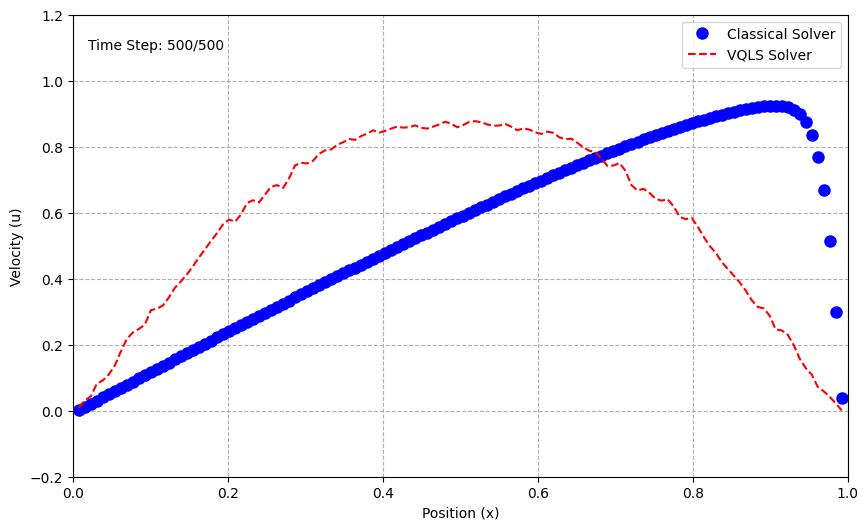

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def run_classical_with_history(max_steps=200):
    """Runs the classical solver and returns the history of solutions."""
    N = 128
    nu = 0.01
    h = 1.0 / (N + 1)
    dt = 1e-3
    A = build_A(N, nu, dt, h)
    x_grid = np.linspace(1, N, N) * h
    u_n = np.sin(np.pi * x_grid)
    
    history = [u_n.copy()]
    for step in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_new = np.linalg.solve(A, u_star)
        u_n = u_new
        history.append(u_n.copy())
        
    print(f"Classical simulation finished. Captured {len(history)} frames.")
    return history, x_grid

def run_vqls_with_history(max_steps=200):
    """Runs the VQLS solver and returns the history of solutions."""
    N = 128
    n_qubits = int(np.log2(N)) 
    nu = 0.01
    h = 1.0 / (N + 1)
    dt = 1e-3
    A = build_A(N, nu, dt, h)
    x_grid = np.linspace(1, N, N) * h
    u_n = np.sin(np.pi * x_grid)
    
    n_params = 10 * n_qubits
    last_params = 0.1 * np.random.randn(n_params)
    
    history = [u_n.copy()]
    for step in range(max_steps):
        print(f"\n--- VQLS Animation Step {step+1}/{max_steps} ---")
        u_star = advect_upwind(u_n.copy(), dt, h)
        vqls = VQLS_Prototype(A=A, b_vec=u_star, n_qubits=n_qubits, reps=10)
        
        res = minimize(vqls.cost, last_params, method='COBYLA', options={'maxiter': 2000})
        last_params = res.x
        u_rec, _ = vqls.reconstruct_solution(res.x)
        u_n = u_rec
        history.append(u_n.copy())

    print(f"VQLS simulation finished. Captured {len(history)} frames.")
    return history, x_grid


if __name__ == "__main__":
    num_frames = 500
    classical_history, x_grid = run_classical_with_history(max_steps=num_frames)
    vqls_history, _ = run_vqls_with_history(max_steps=num_frames)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(0, 1)
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Velocity (u)")
    ax.grid(True, linestyle='--')

    line_classical, = ax.plot(x_grid, classical_history[0], 'bo', label="Classical Solver", markersize=8)
    line_vqls, = ax.plot(x_grid, vqls_history[0], 'r--', label="VQLS Solver")
    
    ax.legend()
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, va='top')

    def update(frame):
        """Updates the plot for each frame of the animation."""
        line_classical.set_ydata(classical_history[frame])
        line_vqls.set_ydata(vqls_history[frame])
        time_text.set_text(f'Time Step: {frame}/{num_frames}')
        return line_classical, line_vqls, time_text

    ani = animation.FuncAnimation(fig, update, frames=num_frames + 1,
                                  blit=True, interval=50)

    print("\nSaving animation... This will take some time for 500 frames.")
    ani.save('simulation_comparison_128_grid_points.gif', writer='pillow', fps=20)
    print("Animation saved as simulation_comparison_128_grid_points.gif")
    
    plt.show()

Classical simulation finished. Captured 501 frames.

Saving animation... This will take some time for 500 frames.
Animation saved as simulation_gaussian_initial_condition.gif


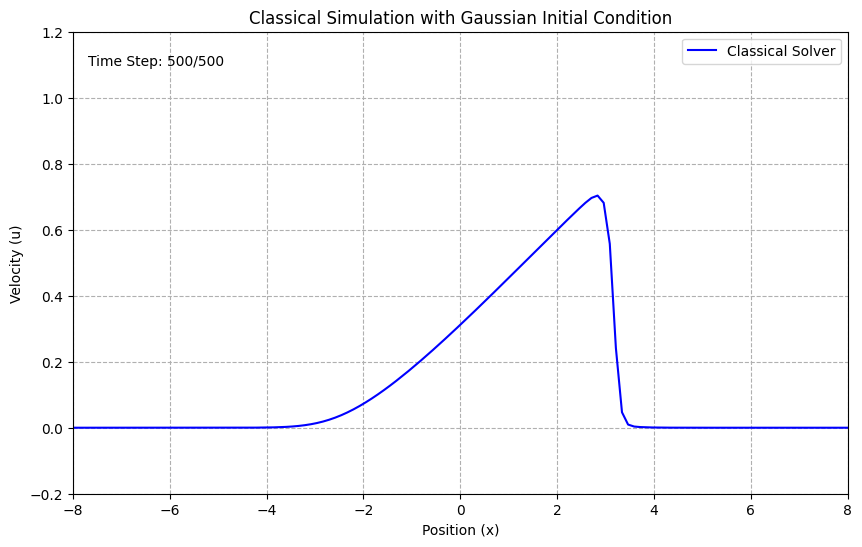

In [4]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
def run_classical_with_history(max_steps=200):
    """Runs the classical solver with a Gaussian initial condition."""
    N = 128
    nu = 0.01

    x_grid = np.linspace(-8, 8, N)
    h = x_grid[1] - x_grid[0]
    
    dt = 0.01
    A = build_A(N, nu, dt, h)
    
    u_n = np.exp(-x_grid**2 / 2)
    
    history = [u_n.copy()]
    for step in range(max_steps):
        u_star = advect_upwind(u_n.copy(), dt, h)
        u_new = np.linalg.solve(A, u_star)
        u_n = u_new
        history.append(u_n.copy())
        
    print(f"Classical simulation finished. Captured {len(history)} frames.")
    return history, x_grid


if __name__ == "__main__":
    num_frames = 500
    classical_history, x_grid = run_classical_with_history(max_steps=num_frames)

    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_ylim(-0.2, 1.2)
    ax.set_xlim(-8, 8)
    ax.set_xlabel("Position (x)")
    ax.set_ylabel("Velocity (u)")
    ax.set_title("Classical Simulation with Gaussian Initial Condition")
    ax.grid(True, linestyle='--')

    line_classical, = ax.plot(x_grid, classical_history[0], 'b-', label="Classical Solver")
    
    ax.legend()
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, va='top')

    def update(frame):
        """Updates the plot for each frame of the animation."""
        line_classical.set_ydata(classical_history[frame])
        time_text.set_text(f'Time Step: {frame}/{num_frames}')
        return line_classical, time_text

    ani = animation.FuncAnimation(fig, update, frames=num_frames + 1, blit=True, interval=50)

    print("\nSaving animation... This will take some time for 500 frames.")
    ani.save('simulation_gaussian_initial_condition.gif', writer='pillow', fps=20)
    print("Animation saved as simulation_gaussian_initial_condition.gif")
    
    plt.show()